In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization, used to plot total count for each label
import random # used to split trainig and testing data
import warnings
import os # used to iterate through all the images in the specified directory
import tensorflow as tf
import math

# libraries used for loading images and visualization
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

# libraries to split the data into training and testing data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.image import ImageDataGenerator

# libraries to build the model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

## Import Data
- Import the excel file containing the ID and Pawpularity Scores for the training data
- Then import all the image files and put them in a dataframe with the scores as the *label*

In [45]:
# import data from csv
train_csv = pd.read_csv (r'C:\Users\Rebecca\Documents\Virginia_Tech\SP22\AdvML\pawpularity_data\train.csv')
train_csv.head()

pawpularity_scores = train_csv.loc[:,"Pawpularity"]
#print(np.array(pawpularity_scores))
scores = np.array(pawpularity_scores)

# Set scores to be rounded down (i.e. 30-39% = 30%)
rounded_scores = []
scores_array = np.array(pawpularity_scores)
for ii in range(len(scores_array)):
    rounded_scores.append(round(math.floor(scores_array[ii]/10))*10)
#print(rounded_scores[0:5])

# Set as raw scores
raw_scores = pawpularity_scores.to_frame()

# greater than or less than 50
half_scores = []
for jj in range(len(scores)):
    if scores[jj] < 50:
        half_scores.append(0)
    else:
        half_scores.append(100)

# split by 20's
twenty_split = []
for kk in range(len(scores)):
    if scores[kk] <= 20:
        twenty_split.append(0)
    elif scores[kk] > 20 and scores[kk] <= 40:
        twenty_split.append(1)
    elif scores[kk] > 40 and scores[kk] <= 60:
        twenty_split.append(2)
    elif scores[kk] > 80 and scores[kk] <= 80:
        twenty_split.append(3)
    else:
        twenty_split.append(4)

# split by 100 and otherwise
bin_split = []
for pp in range(len(scores)):
    if scores[pp] == 100:
        bin_split.append(100)
    else:
        bin_split.append(0)

# bin split and otherwise in the middle
tri_split = []
for qq in range(len(scores)):
    if scores[qq] == 100:
        tri_split.append(100)
    elif scores[qq] <= 10:
        tri_split.append(0)
    else:
        tri_split.append(50)


In [3]:
# import image data as a dataframe
img_path = [] # store image paths for all images (all images are size 256x256)
dataset_folder = 'train'

# iterate through all of the images to create a binary array corresponding to the image labels
for img in os.listdir(dataset_folder):
    img_path.append(os.path.join(dataset_folder, img))

# total number of images and labels should match
print(img_path[1])
print("total number of images: ", len(img_path))

# now create the dataframe
df = pd.DataFrame()
df['images'] = img_path
df['label'] = rounded_scores # change based on rounded or raw


df = df.sample(frac=1).reset_index(drop=True) # randomize the images, rather than having them be in order

df.head()

train\0009c66b9439883ba2750fb825e1d7db.jpg
total number of images:  9912


,images,label
0,train\b7950664b26af7e82369ce3fa7d8e356.jpg,40
1,train\f8177eb2b1045d05f3e3224538e7e622.jpg,40
2,train\e62c676d8d429e5f657078b418ab1602.jpg,0
3,train\b62c7148e72cc49d0ee89c4a523d56be.jpg,30
4,train\70b3340d024f77a06b12dffab2e51029.jpg,40


### Plotting
#### Some Example Images and a Plot of the Distribution of Scores

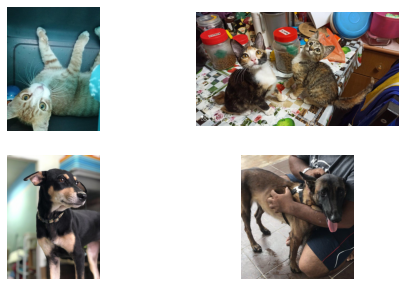

In [99]:
## Plot a couple of the images
plt.figure(figsize=(8,5)) # display grid of images
temp = df['images']
start = random.randint(0, len(temp))
files = temp[start:start+4]

for index,file in enumerate(files):
    plt.subplot(2,2,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')

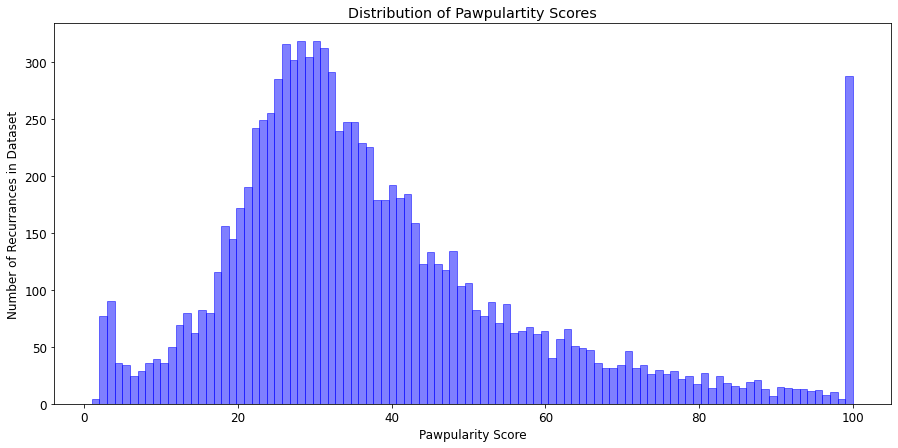

In [100]:
# plot the distribution of the scores
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 12})
plt.hist(raw_scores, 100, facecolor='b', alpha=0.5, edgecolor='blue')
plt.xlabel("Pawpularity Score")
plt.ylabel("Number of Recurrances in Dataset")
plt.title("Distribution of Pawpulartity Scores")
plt.show()

---------------------------------------------------------------------
## **CNN (Classification)**
---------------------------------------------------------------------
### Split into training and validation data

In [ ]:
x_train, x_val = train_test_split(df, test_size=0.2)

# convert y-col to str for binary class_mode
#y_train = np.array(y_train)
#y_val = np.array(y_val)
x_train['label'] = x_train['label'].astype('str')
x_val['label']  = x_val['label'].astype('str')

print('training data: \n', x_train.head())

print('\nvalidation data: \n', x_val.head())

### Preprocess the data
First normalize the image data (pixels go from 0 to 1)

Then generate the batches of images that will be sent into the model

In [ ]:
# NORMALIZE
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest',
)
test_gen = ImageDataGenerator(
    rescale=1./255,
)

# -----------------------------------------
#           GENERATE BATCHES

train_data = train_gen.flow_from_dataframe(
    x_train,
    x_col='images',
    y_col='label',
    target_size=(128,128), 
    #color_mode='grayscale',
    batch_size= 512*2, 
    class_mode='categorical'
)

val_data = test_gen.flow_from_dataframe(
    x_val,
    x_col='images',
    y_col='label',
    target_size=(128,128), 
    #color_mode='grayscale',
    batch_size= 512*2,
    class_mode='categorical'
)

### Build the model

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_hinge', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(train_data, epochs=1, validation_data=val_data)

### Run prediction

---------------------------------------------------------------------
## **KNN**
---------------------------------------------------------------------
### Start by preprocessing the data


In [4]:
# import a couple more libraries needed for preprocessing
import argparse
import imutils
import cv2

In [5]:
## ----------------------------------------
##    Convert Images to Feature Vectors
## ----------------------------------------
def image_to_feature_vector(image, size=(128,128)):
    return cv2.resize(image,size).flatten()

## ----------------------------------------
##    Characterize Color Distribution
## ----------------------------------------
def extract_color_histogram(image, bins=(8,8,8)):
    # extract a 3D color histogram from HSV color space using supplied # of bins per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180,0,256,0,256])

    # normalize the histograms
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else:
        cv2.normalize(hist,hist)

    # return flattened histogram as the feature vector
    return hist.flatten()

## ----------------------------------------
##    Parse Command Line Arguments
## ----------------------------------------
# construct the argument parse and parse the arguments
'''
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True, help="path to input dataset")
ap.add_argument("-k", "--neighbors", type=int, default=1, help="# of nearest neighbors for classification")
ap.add_argument("-j", "--jobs", type=int, default=-1, help="# of jobs for KNN distances (-1 uses all available cores)")
args = vars(ap.parse_args()) 
'''

'\nap = argparse.ArgumentParser()\nap.add_argument("-d", "--dataset", required=True, help="path to input dataset")\nap.add_argument("-k", "--neighbors", type=int, default=1, help="# of nearest neighbors for classification")\nap.add_argument("-j", "--jobs", type=int, default=-1, help="# of jobs for KNN distances (-1 uses all available cores)")\nargs = vars(ap.parse_args()) \n'

In [6]:
## -----------------------------------------------------------------
##                      EXTRACT FEATURES
## -----------------------------------------------------------------
rawImages = []
features = []

for (i, imagePath) in enumerate(img_path):
    img = cv2.imread(imagePath)

    pixels = image_to_feature_vector(img)
    hist = extract_color_histogram(img)

    rawImages.append(pixels)
    features.append(hist)

    if (i > 0 and i % 1000 == 0):
        print("[INFO] processed {}/{}".format(i, len(img_path)))
    

[INFO] processed 1000/9912
[INFO] processed 2000/9912
[INFO] processed 3000/9912
[INFO] processed 4000/9912
[INFO] processed 5000/9912
[INFO] processed 6000/9912
[INFO] processed 7000/9912
[INFO] processed 8000/9912
[INFO] processed 9000/9912


### Split into testing and validation data

In [74]:
rawImages = np.array(rawImages)
features = np.array(features)
labels = bin_split # raw_scores | rounded_scores | half_scores | twenty_split | tri_split | bin_split

# 80 - 20 split
(trainImgs, valImgs, trainLbls, valLbls) = train_test_split(rawImages, labels, test_size=0.2, random_state=42)
(trainFt, valFt, trainFLbls, valFLbls)     = train_test_split(features,  labels, test_size=0.2, random_state=42)

### Perform KNN Classification

In [21]:
# KNN Classification on RAW PIXELS
acc = []
s=0
for k in range(11):
    print("[INFO] k-neighbors = ", s+k+1)
    print("[INFO] evaluating raw pixel accuracy...")
    model = KNeighborsClassifier(n_neighbors=s+k+1)
    model.fit(trainImgs, trainLbls)
    acc.append(model.score(valImgs, valLbls))

    print("[RESULT] raw pixel accuracy: {:.2f}%".format(acc[k]*100))


[INFO] k-neighbors =  1
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 2.22%
[INFO] k-neighbors =  2
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 2.47%
[INFO] k-neighbors =  3
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 2.37%
[INFO] k-neighbors =  4
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 2.37%
[INFO] k-neighbors =  5
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 1.97%
[INFO] k-neighbors =  6
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 2.17%
[INFO] k-neighbors =  7
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 2.02%
[INFO] k-neighbors =  8
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 1.92%
[INFO] k-neighbors =  9
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 1.87%
[INFO] k-neighbors =  10
[INFO] evaluating raw pixel accuracy...
[RESULT] raw pixel accuracy: 2.07%
[INFO] k-

In [75]:
# KNN Classification on FEATURES
acc = []
s=0
for k in range(50):
    print("[INFO] k-neighbors = ", s+k+1)
    #print("[INFO] evaluating raw pixel accuracy...")
    model = KNeighborsClassifier(n_neighbors=s+k+1)
    model.fit(trainFt, trainFLbls)
    acc.append(model.score(valFt, valFLbls))

    print("[RESULT] histogram accuracy: {:.2f}%".format(acc[k]*100))

[INFO] k-neighbors =  1
[RESULT] histogram accuracy: 94.45%
[INFO] k-neighbors =  2
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  3
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  4
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  5
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  6
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  7
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  8
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  9
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  10
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  11
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  12
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  13
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  14
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  15
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  16
[RESULT] histogram accuracy: 96.62%
[INFO] k-neighbors =  17
[RESULT]

0.9662128088754413


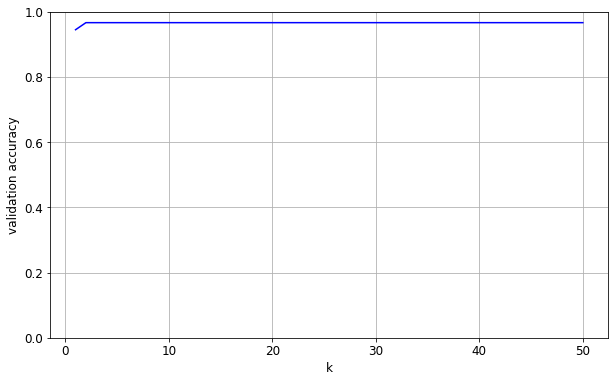

In [76]:
## ----------------------------------
#         Plot the Results
## ----------------------------------
k=np.linspace(1,50,50)
val_accuracy = acc
max_acc = np.argmax(val_accuracy)
print(val_accuracy[max_acc])

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(k, val_accuracy, 'b')
#plt.plot(max_acc+1, val_accuracy[max_acc], 'r', marker='o', markersize=7)
plt.ylim([0,1])
plt.xlabel("k")
plt.ylabel("validation accuracy")
plt.grid('on')
plt.show()

In [ ]:
pred = model.predict(y)
np.shape(pred)


In [ ]:
x = test_data[0][1][150]
np.shape(x)

In [ ]:
y= np.reshape(x, (1, 128, 128, 3))

In [ ]:
print(pred)

In [ ]:
x

In [ ]:
np.where(x==1)

In [7]:
x = 4

In [ ]:
import math
round(math.floor(x/10))*10